In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
default_figsize = plt.rcParamsDefault['figure.figsize']
import seaborn as sns
sns.set_theme()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/predict-energy-behavior-of-prosumers/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/electricity_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/weather_station_to_county_mapping.csv
/kaggle/input/predict-energy-behavior-of-prosumers/public_timeseries_testing_util.py
/kaggle/input/predict-energy-behavior-of-prosumers/historical_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/county_id_to_name_map.json
/kaggle/input/predict-energy-behavior-of-prosumers/train.csv
/kaggle/input/predict-energy-behavior-of-prosumers/forecast_weather.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/sample_submission.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/client.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/gas_prices.csv
/kaggle/input/predict-energy-behavior-of-prosumers/example_test_files/electricity

In [2]:
!pip install mlforecast lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.4 MB/s eta 0:00:00


# Data setup

In [3]:
train_df = pd.read_csv("/kaggle/input/predict-energy-behavior-of-prosumers/train.csv",
                            parse_dates=["datetime"]
                                   )
train_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [4]:
consumption = train_df[train_df["is_consumption"]==1]
display(consumption.head())
production = train_df[train_df["is_consumption"]==0]
display(production.head())

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
1,0,0,1,96.590,1,2021-09-01,0,1,0
3,0,0,2,17.314,1,2021-09-01,0,3,1
5,0,0,3,656.859,1,2021-09-01,0,5,2
7,0,1,0,59.000,1,2021-09-01,0,7,3
9,0,1,1,501.760,1,2021-09-01,0,9,4


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
4,0,0,3,2.904,0,2021-09-01,0,4,2
6,0,1,0,0.000,0,2021-09-01,0,6,3
8,0,1,1,0.000,0,2021-09-01,0,8,4


In [5]:
df = consumption[["prediction_unit_id", "datetime", "target"]].rename(columns={"prediction_unit_id": "unique_id", "datetime": "ds", "target": "y"})
df

,unique_id,ds,y
1,0,2021-09-01 00:00:00,96.590
3,1,2021-09-01 00:00:00,17.314
5,2,2021-09-01 00:00:00,656.859
7,3,2021-09-01 00:00:00,59.000
9,4,2021-09-01 00:00:00,501.760
...,...,...,...
2018343,57,2023-05-31 23:00:00,42.401
2018345,58,2023-05-31 23:00:00,117.332
2018347,64,2023-05-31 23:00:00,197.233
2018349,59,2023-05-31 23:00:00,28.404


# Distribution of means

In [6]:
series_means = pd.pivot_table(data=df, index="unique_id", values="y", aggfunc="mean")

<Axes: xlabel='y'>

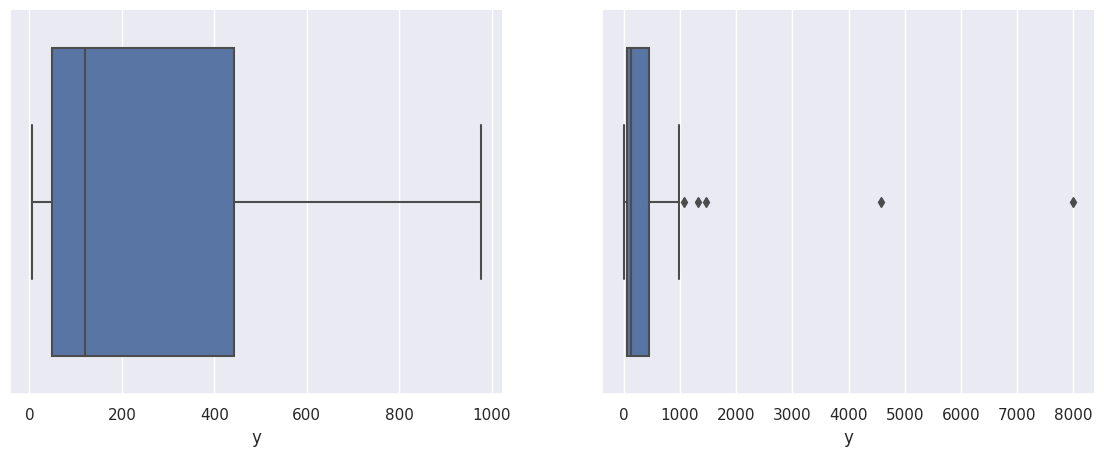

In [7]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.boxplot(x=series_means["y"], ax=ax0, showfliers=False)
sns.boxplot(x=series_means["y"], ax=ax1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='y', ylabel='Count'>

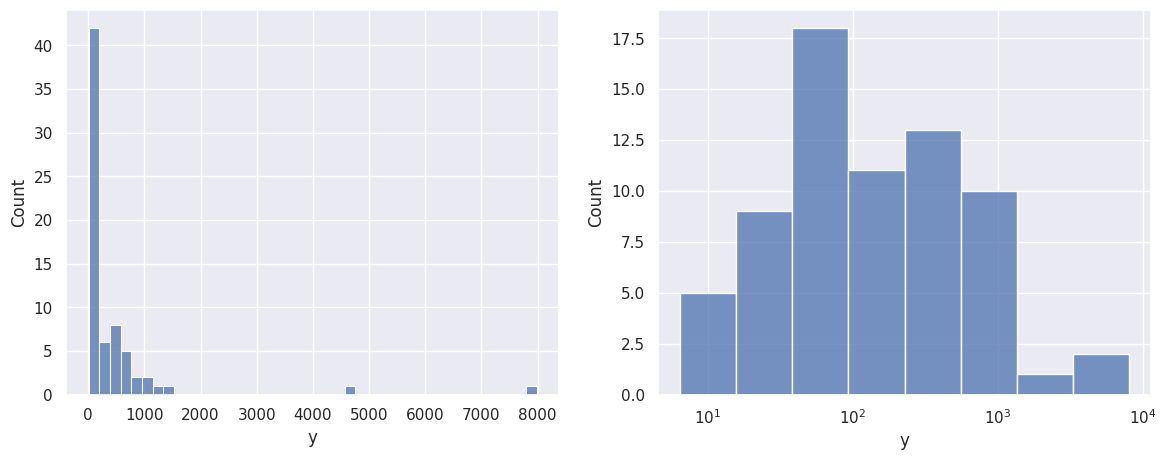

In [8]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(x=series_means["y"], ax=ax0)
sns.histplot(x=series_means["y"], ax=ax1, log_scale=True)

# Filling NaN values

In [9]:
df.isna().sum()

unique_id      0
ds             0
y            264
dtype: int64

There are very few NaN values as we can see by taking the mean

In [10]:
df.isna().mean()

unique_id    0.000000
ds           0.000000
y            0.000262
dtype: float64

Because there are almost no NaN values, we are going to use a linear interpolation

In [11]:
df.interpolate(method="linear", inplace=True)

# Train/Test split

# Models

In [12]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

# Forecast object

In [13]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [14]:
fcst = MLForecast(
    models=models,
    freq='h',
    lags=[i+1 for i in range(25)],
#     lag_transforms={
#         1: [ExpandingMean()],
#         7: [RollingMean(window_size=28)]
#     },
    date_features=["month", "dayofweek"],
#     target_transforms=[Differences([1])],
)


# Training

In [15]:
%%time
fcst.fit(df)

CPU times: user 27.4 s, sys: 1.7 s, total: 29.1 s
Wall time: 17.8 s


MLForecast(models=[LGBMRegressor, LinearRegression], freq=h, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23', 'lag24', 'lag25'], date_features=['month', 'dayofweek'], num_threads=1)

# Inference

In [16]:
predictions = fcst.predict(48)
predictions

,unique_id,ds,LGBMRegressor,LinearRegression
0,0,2023-06-01 00:00:00,507.634865,501.335864
1,0,2023-06-01 01:00:00,489.724957,467.230190
2,0,2023-06-01 02:00:00,475.016730,455.244207
3,0,2023-06-01 03:00:00,454.485152,446.063835
4,0,2023-06-01 04:00:00,427.219873,424.647720
...,...,...,...,...
3307,68,2023-06-02 19:00:00,11.191276,6.533616
3308,68,2023-06-02 20:00:00,11.191276,7.264086
3309,68,2023-06-02 21:00:00,11.191276,8.918760
3310,68,2023-06-02 22:00:00,11.191276,10.386799


# Visualize results

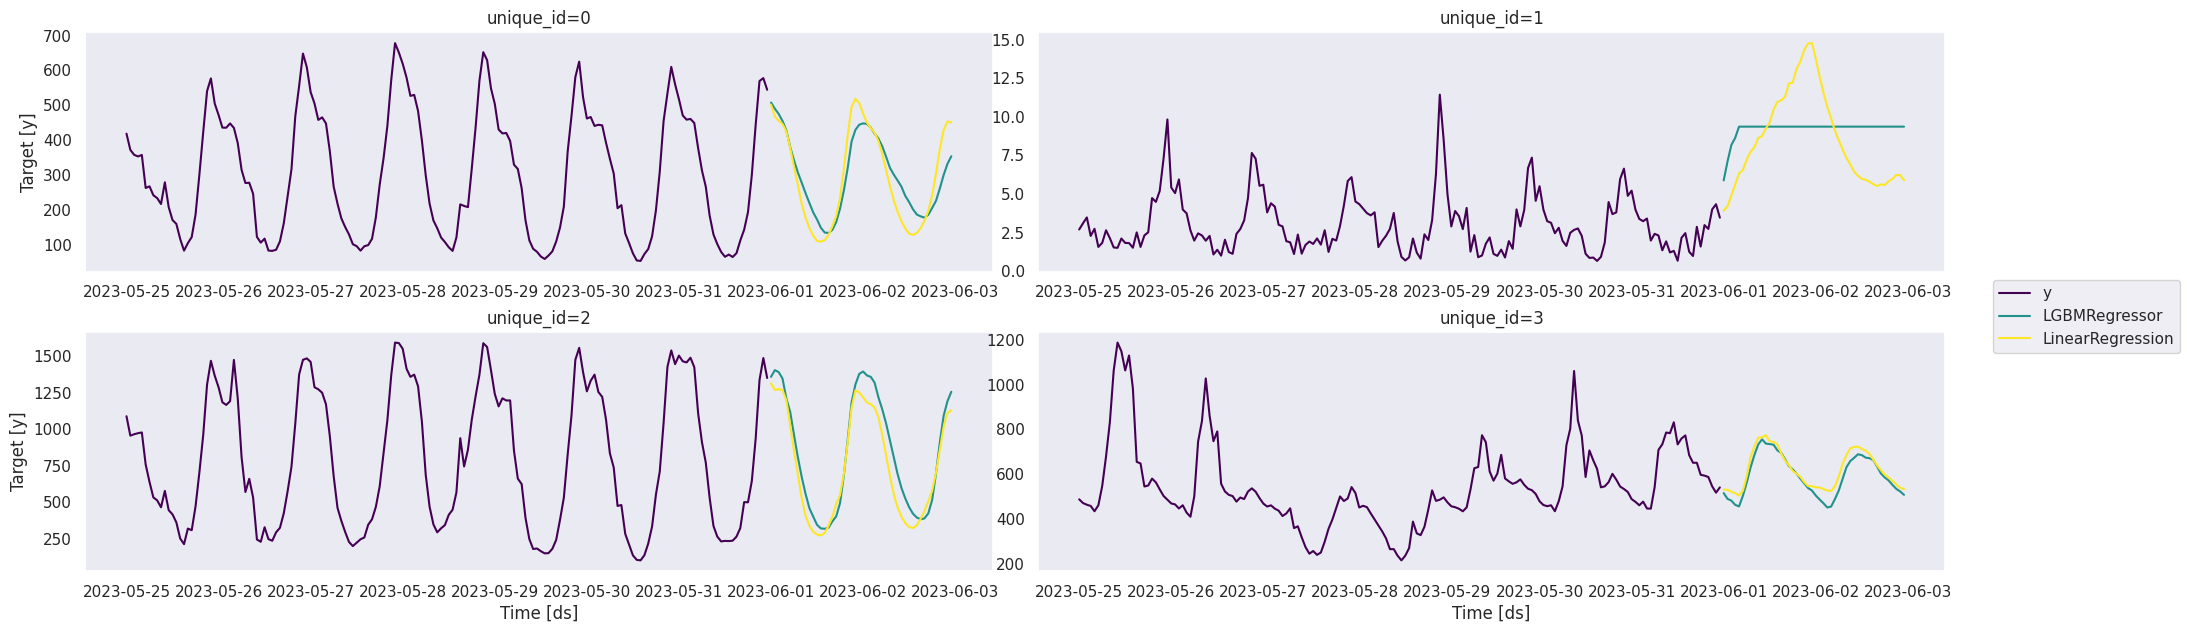

In [17]:
from utilsforecast.plotting import plot_series

fig = plot_series(df, predictions, max_ids=4, max_insample_length=24*7, plot_random=False)
fig

# Differencing the time series

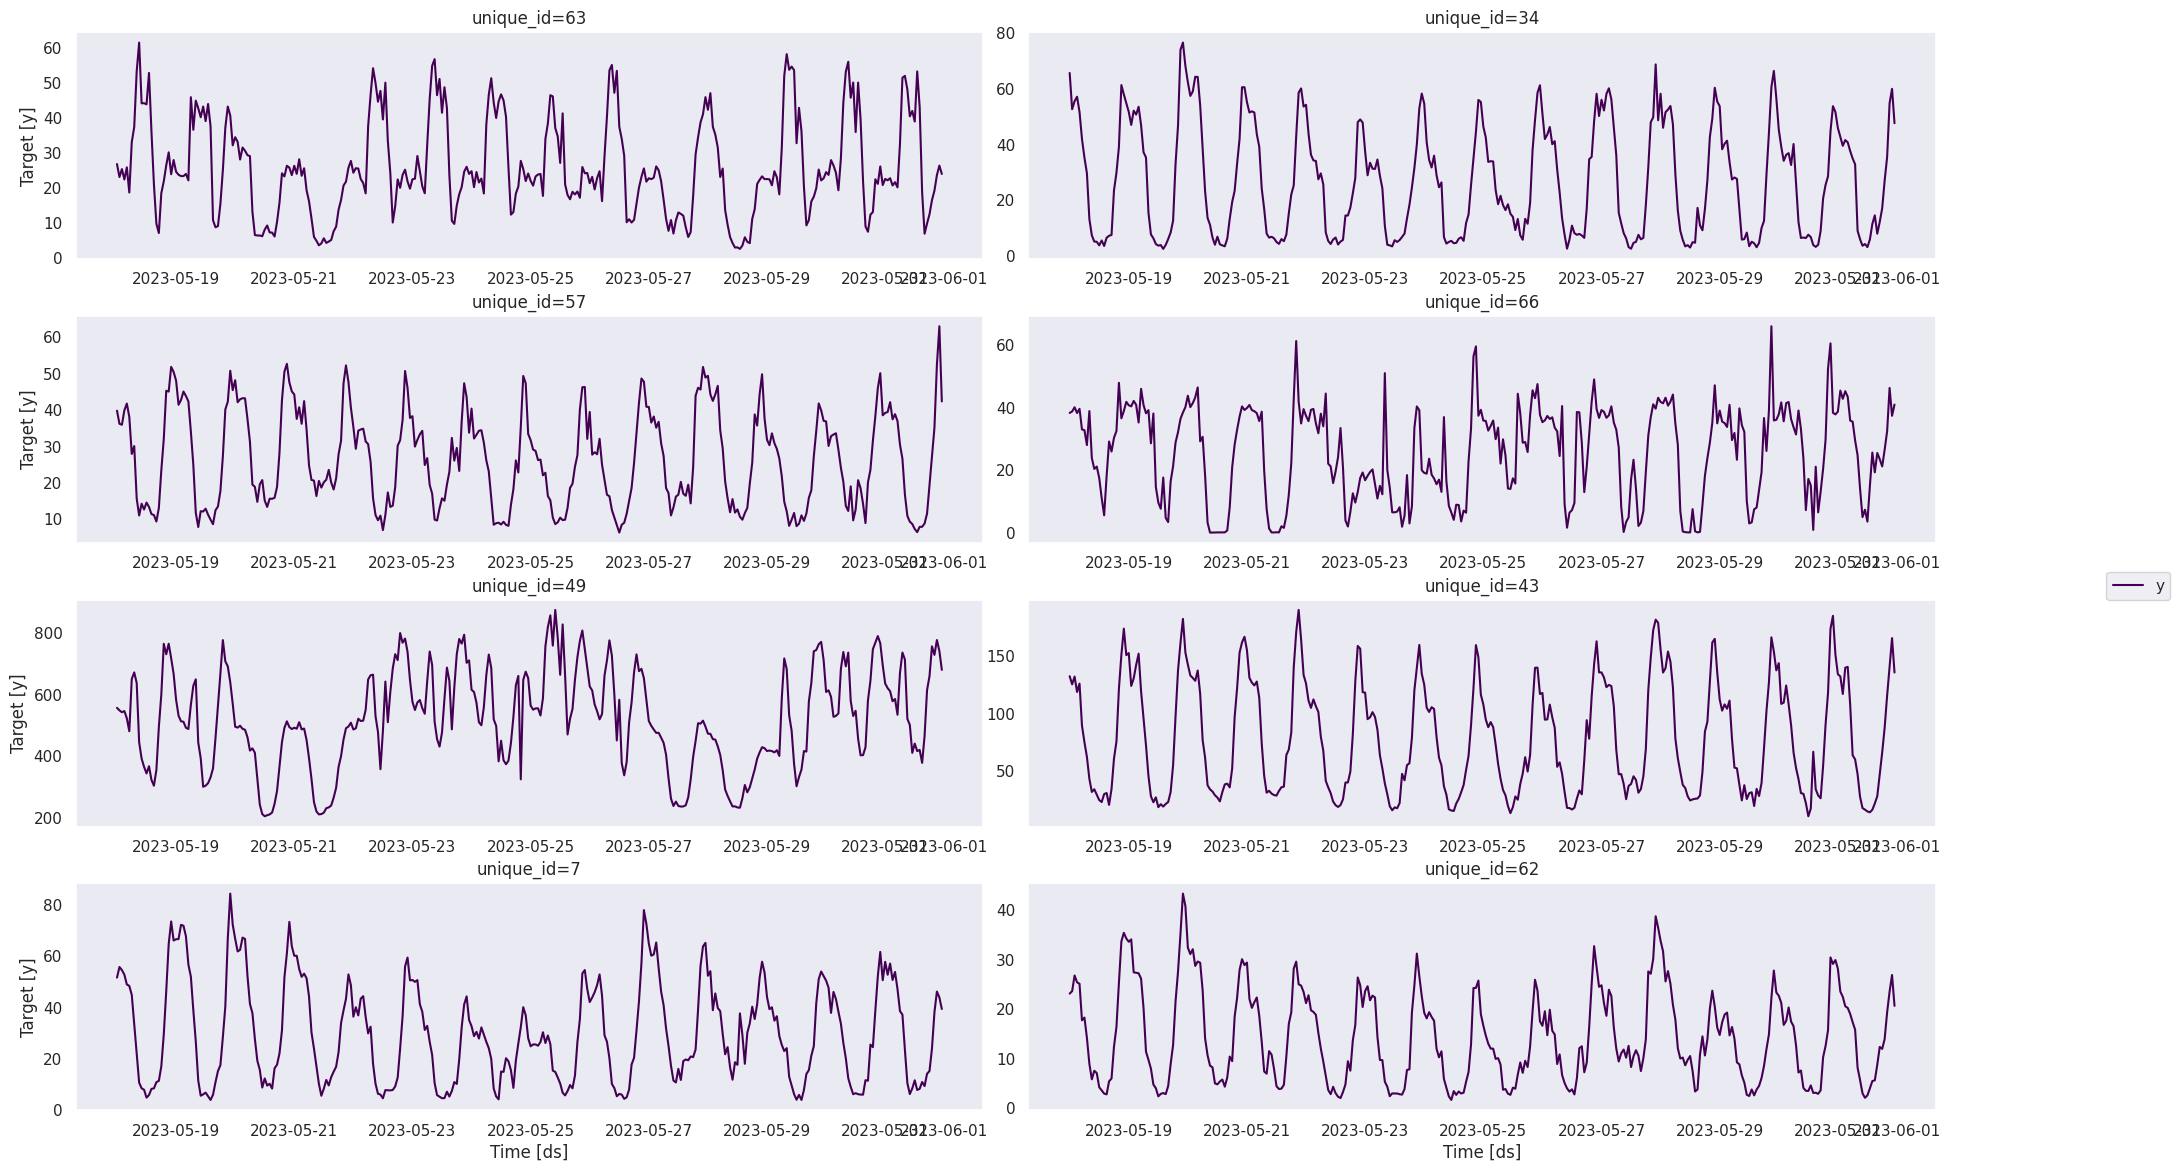

In [18]:
plot_series(df, max_insample_length=24*14)

In [19]:
fcst = MLForecast(
    models=[],  # we're not interested in modeling yet
    freq="h",
    target_transforms=[Differences([48])],  # substract the value from the same hour two days before
)
prep = fcst.preprocess(df)
prep

,unique_id,ds,y
5857,0,2021-09-03 00:00:00,10.539
5859,1,2021-09-03 00:00:00,2.316
5861,2,2021-09-03 00:00:00,34.049
5863,3,2021-09-03 00:00:00,5.100
5865,4,2021-09-03 00:00:00,28.212
...,...,...,...
2018343,57,2023-05-31 23:00:00,5.343
2018345,58,2023-05-31 23:00:00,6.711
2018347,64,2023-05-31 23:00:00,9.066
2018349,59,2023-05-31 23:00:00,-3.080


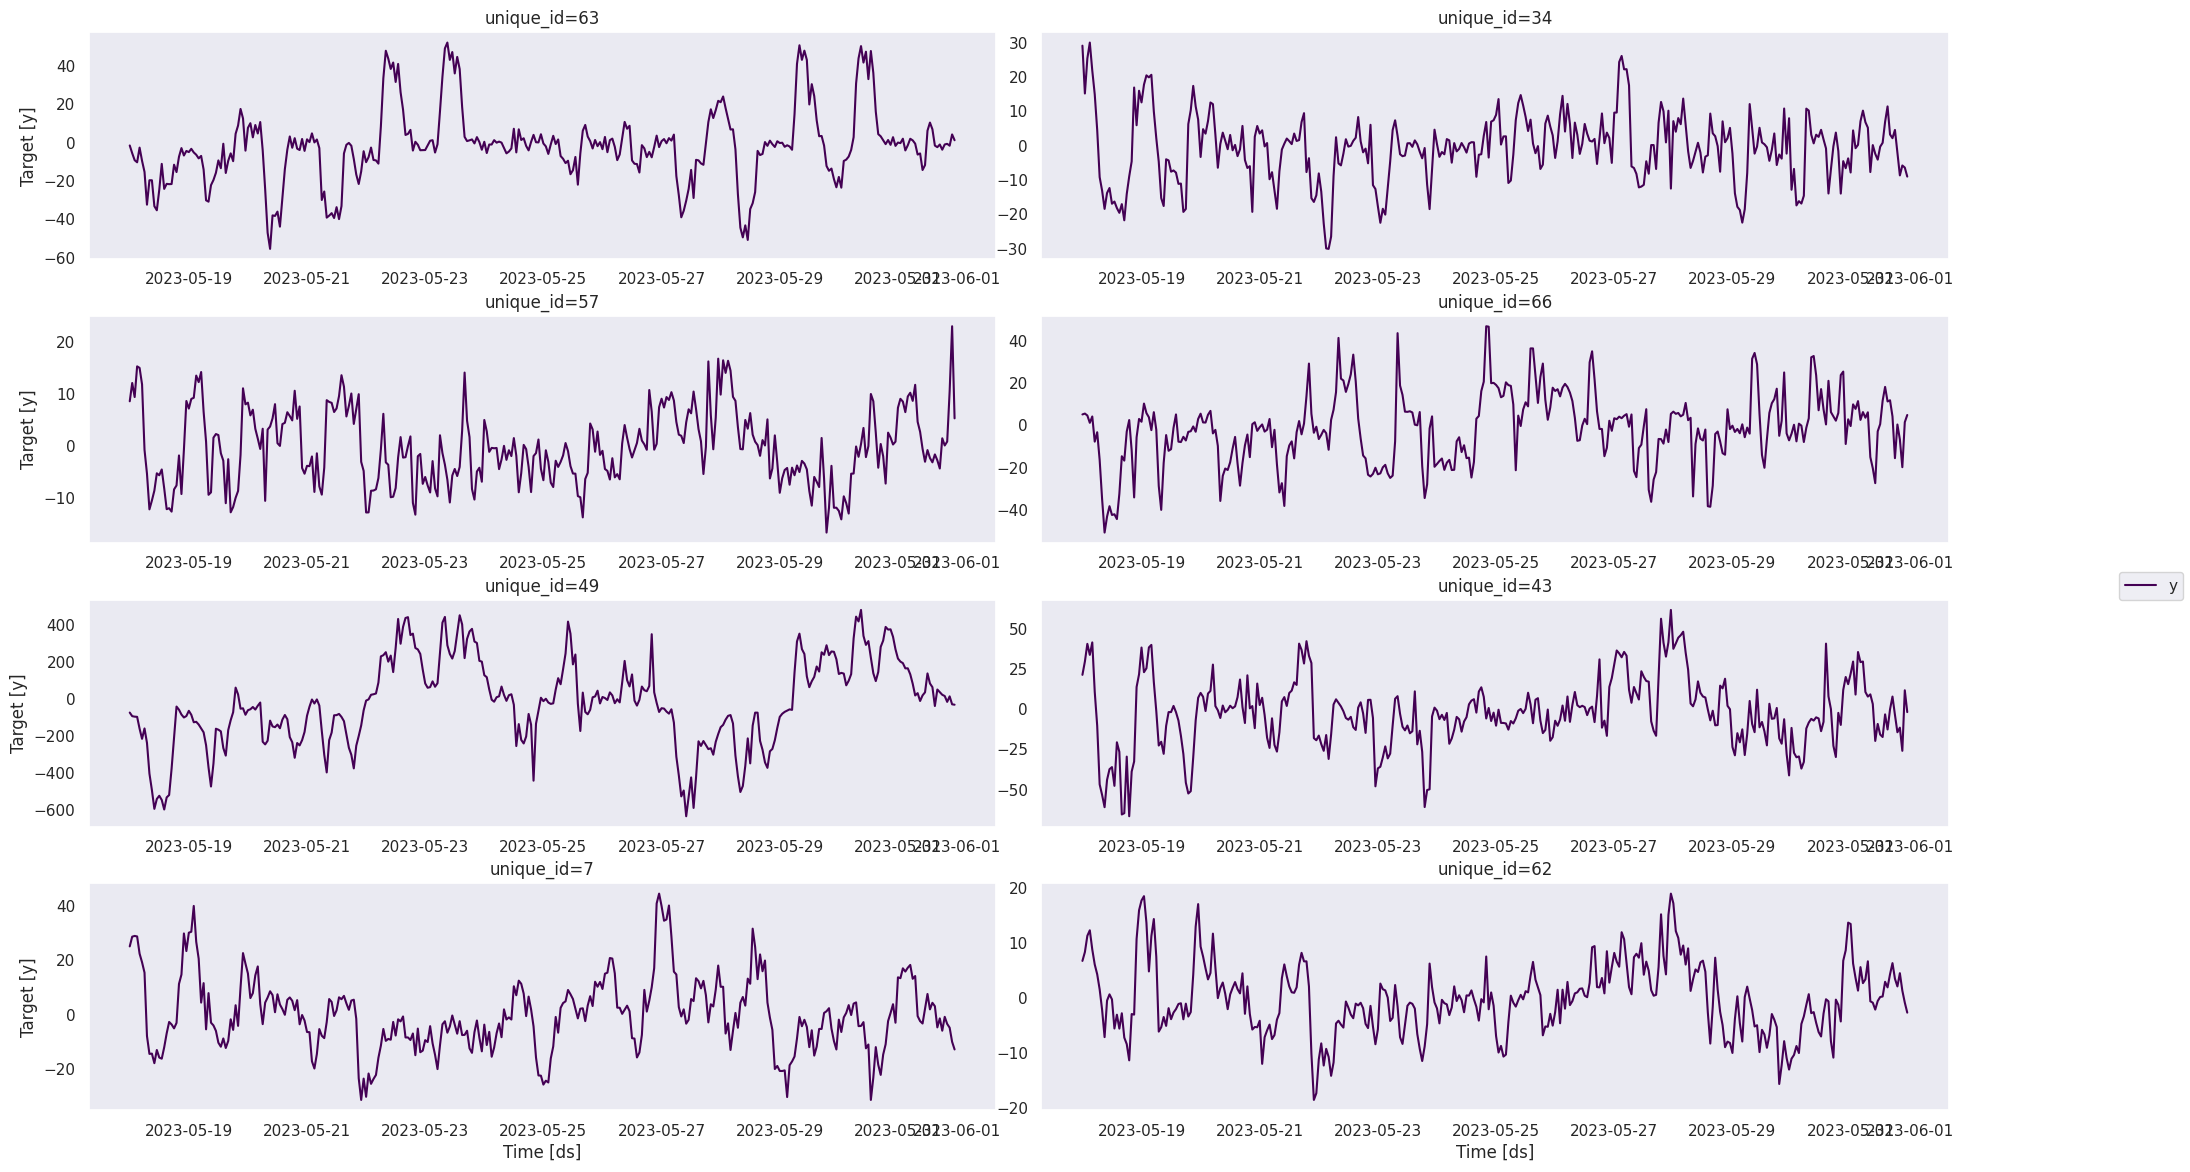

In [20]:
plot_series(prep, max_insample_length=24*14)

# Lag transforms

In [21]:
fcst = MLForecast(
    models=[],
    freq="h",
    target_transforms=[Differences([48])],    
    lag_transforms={
#         1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
)
prep = fcst.preprocess(df)
prep

,unique_id,ds,y,rolling_mean_lag24_window_size48
14519,0,2021-09-05 23:00:00,-3.103,8.364375
14521,1,2021-09-05 23:00:00,-4.603,1.513625
14523,2,2021-09-05 23:00:00,-34.886,58.265146
14525,3,2021-09-05 23:00:00,-0.700,-12.387500
14527,4,2021-09-05 23:00:00,-62.221,-47.447271
...,...,...,...,...
2018343,57,2023-05-31 23:00:00,5.343,-4.599125
2018345,58,2023-05-31 23:00:00,6.711,-6.259500
2018347,64,2023-05-31 23:00:00,9.066,288.573937
2018349,59,2023-05-31 23:00:00,-3.080,18.814438


# Date features

In [22]:
df["ds"].dt.hour

1           0
3           0
5           0
7           0
9           0
           ..
2018343    23
2018345    23
2018347    23
2018349    23
2018351    23
Name: ds, Length: 1009176, dtype: int32

In [23]:
def hour_index(ds):
    return ds.hour

fcst = MLForecast(
    models=[],
    freq="h",
    target_transforms=[Differences([24])],
    date_features=[hour_index],
)
fcst.preprocess(df)

,unique_id,ds,y,hour_index
2929,0,2021-09-02 00:00:00,12.776,0
2931,1,2021-09-02 00:00:00,3.694,0
2933,2,2021-09-02 00:00:00,78.837,0
2935,3,2021-09-02 00:00:00,16.800,0
2937,4,2021-09-02 00:00:00,0.481,0
...,...,...,...,...
2018343,57,2023-05-31 23:00:00,3.813,23
2018345,58,2023-05-31 23:00:00,1.844,23
2018347,64,2023-05-31 23:00:00,-266.717,23
2018349,59,2023-05-31 23:00:00,-5.428,23


# Target transformations

In [24]:
from mlforecast.target_transforms import LocalStandardScaler

In [25]:
LocalStandardScaler?

In [26]:
fcst = MLForecast(
    models=[],
    freq="h",
    lags=[1],
    target_transforms=[LocalStandardScaler()]  # Standardizes each serie by subtracting its mean and dividing by its standard deviation
)
fcst.preprocess(df)

,unique_id,ds,y,lag1
123,0,2021-09-01 01:00:00,-1.154303,-1.094468
125,1,2021-09-01 01:00:00,-0.490043,-0.393298
127,2,2021-09-01 01:00:00,-0.852380,-0.780298
129,3,2021-09-01 01:00:00,-0.989537,-0.994524
131,4,2021-09-01 01:00:00,-1.036857,-0.996780
...,...,...,...,...
2018343,57,2023-05-31 23:00:00,0.122663,0.881637
2018345,58,2023-05-31 23:00:00,0.428945,0.691748
2018347,64,2023-05-31 23:00:00,-0.633065,-0.586131
2018349,59,2023-05-31 23:00:00,-0.735144,-0.624797


# Naive model

In [27]:
from sklearn.base import BaseEstimator

class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

In [28]:
fcst = MLForecast(
    models=[Naive()],
    freq="h",
    lags=[1],
    target_transforms=[LocalStandardScaler()]
)
fcst.fit(df)
preds = fcst.predict(1)
preds

,unique_id,ds,Naive
0,0,2023-06-01,544.221
1,1,2023-06-01,3.459
2,2,2023-06-01,1349.457
3,3,2023-06-01,540.327
4,4,2023-06-01,889.251
...,...,...,...
64,64,2023-06-01,197.233
65,65,2023-06-01,36.632
66,66,2023-06-01,40.941
67,67,2023-06-01,325.267


In [29]:
last_vals = df.groupby('unique_id').tail(1).sort_values(by="unique_id")
last_vals

,unique_id,ds,y
2018223,0,2023-05-31 23:00:00,544.221
2018225,1,2023-05-31 23:00:00,3.459
2018227,2,2023-05-31 23:00:00,1349.457
2018229,3,2023-05-31 23:00:00,540.327
2018231,4,2023-05-31 23:00:00,889.251
...,...,...,...
2018347,64,2023-05-31 23:00:00,197.233
2018247,65,2023-05-31 23:00:00,36.632
2018265,66,2023-05-31 23:00:00,40.941
2018317,67,2023-05-31 23:00:00,325.267


In [30]:
import numpy as np

np.testing.assert_allclose(preds['Naive'], last_vals['y'])

# Training

In [31]:
lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params),
        'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq="h",
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
)

In [32]:
%%time
fcst.fit(df)

CPU times: user 45.8 s, sys: 78.2 ms, total: 45.9 s
Wall time: 45.9 s


MLForecast(models=[avg, q75, q25], freq=h, lag_features=['lag1', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=[<function hour_index at 0x7a07542f8160>], num_threads=1)

# Forecasting

In [33]:
preds = fcst.predict(48)
preds

,unique_id,ds,avg,q75,q25
0,0,2023-06-01 00:00:00,495.548175,511.099716,482.282224
1,0,2023-06-01 01:00:00,456.285249,470.733835,434.331797
2,0,2023-06-01 02:00:00,444.704860,459.236092,418.301897
3,0,2023-06-01 03:00:00,447.917214,462.492773,414.000453
4,0,2023-06-01 04:00:00,440.009682,454.136539,394.113767
...,...,...,...,...,...
3307,68,2023-06-02 19:00:00,1.066883,69.647232,-113.096432
3308,68,2023-06-02 20:00:00,2.788883,60.978874,-104.869082
3309,68,2023-06-02 21:00:00,7.720883,53.983040,-88.544252
3310,68,2023-06-02 22:00:00,11.210883,48.337531,-77.199184


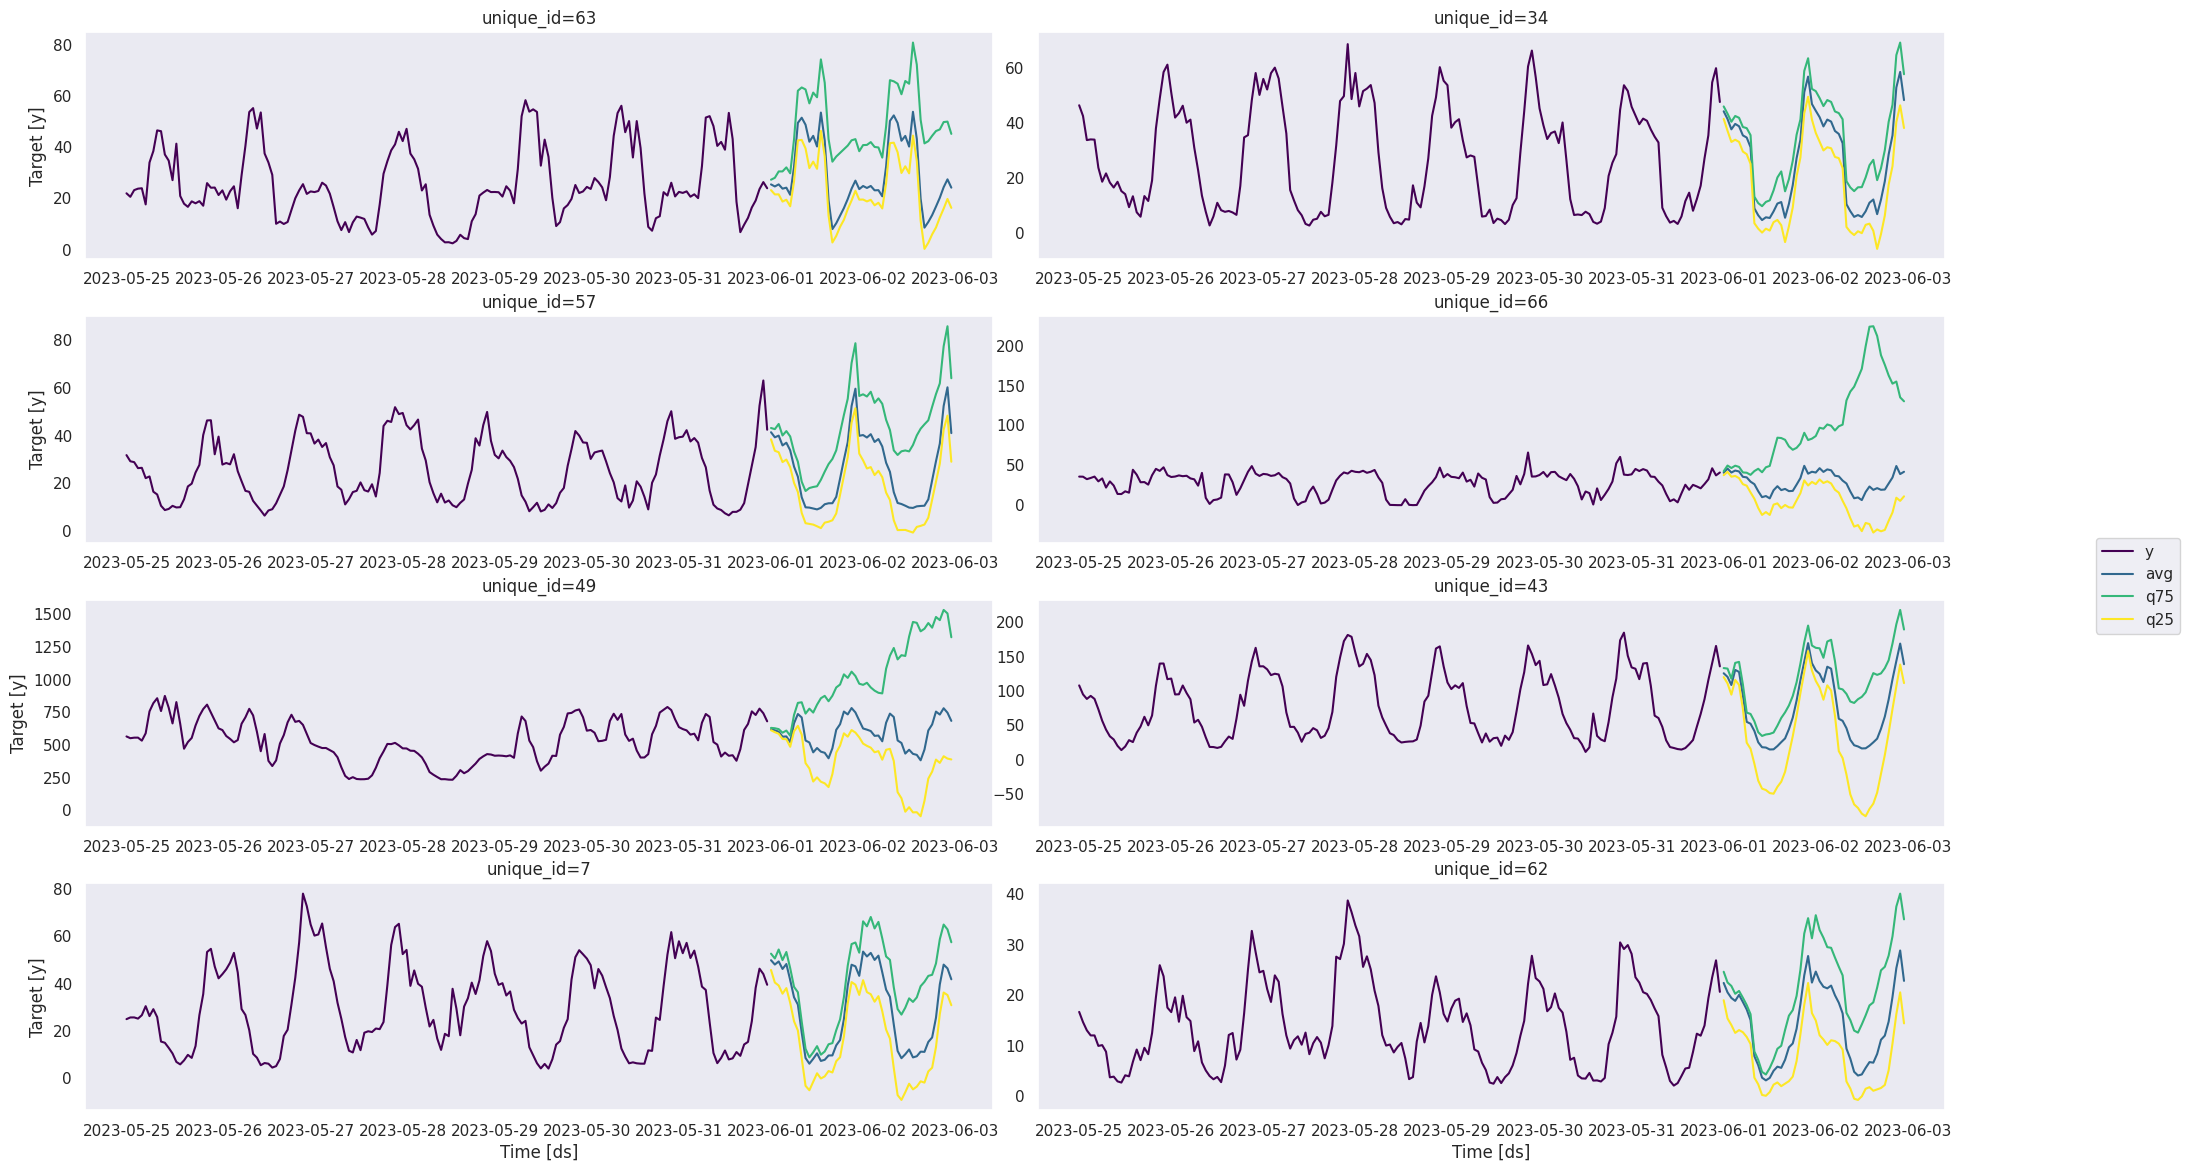

In [34]:
plot_series(df, preds, max_insample_length=24*7)

# Saving and loading

In [35]:
import tempfile
from pathlib import Path

with tempfile.TemporaryDirectory() as tmpdir:
    save_dir = Path(tmpdir) / 'mlforecast'
    fcst.save(save_dir)
    fcst2 = MLForecast.load(save_dir)
    preds2 = fcst2.predict(48)
    pd.testing.assert_frame_equal(preds, preds2)

# Updating series’ values

After you’ve trained a forecast object you can save and load it with the previous methods. If by the time you want to use it you already know the following values of the target you can use the ``MLForecast.update`` method to incorporate these, which will allow you to use these new values when computing predictions.

- If no new values are provided for a serie that’s currently stored, only the previous ones are kept.
- If new series are included they are added to the existing ones.

Example : https://nixtlaverse.nixtla.io/mlforecast/docs/getting-started/end_to_end_walkthrough.html#updating-series-values

# Estimating model performance

## Cross validation

In [36]:
fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq="h",
    target_transforms=[Differences([24])],
    lags=[1, 24],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=[hour_index],
)

In [37]:
%%time

cv_result = fcst.cross_validation(
    df,
    n_windows=4,  # number of models to train/splits to perform
    h=48,  # length of the validation set in each window
)

CPU times: user 41.4 s, sys: 201 ms, total: 41.6 s
Wall time: 41.6 s


In [38]:
cv_result

,unique_id,ds,cutoff,y,LGBMRegressor
0,0,2023-05-24 00:00:00,2023-05-23 23:00:00,426.177,456.622393
1,0,2023-05-24 01:00:00,2023-05-23 23:00:00,399.200,417.277158
2,0,2023-05-24 02:00:00,2023-05-23 23:00:00,382.847,404.321897
3,0,2023-05-24 03:00:00,2023-05-23 23:00:00,390.280,417.963992
4,0,2023-05-24 04:00:00,2023-05-23 23:00:00,360.083,387.222443
...,...,...,...,...,...
13243,68,2023-05-31 19:00:00,2023-05-29 23:00:00,0.257,0.984275
13244,68,2023-05-31 20:00:00,2023-05-29 23:00:00,1.979,2.345020
13245,68,2023-05-31 21:00:00,2023-05-29 23:00:00,6.911,7.612045
13246,68,2023-05-31 22:00:00,2023-05-29 23:00:00,10.401,11.010000


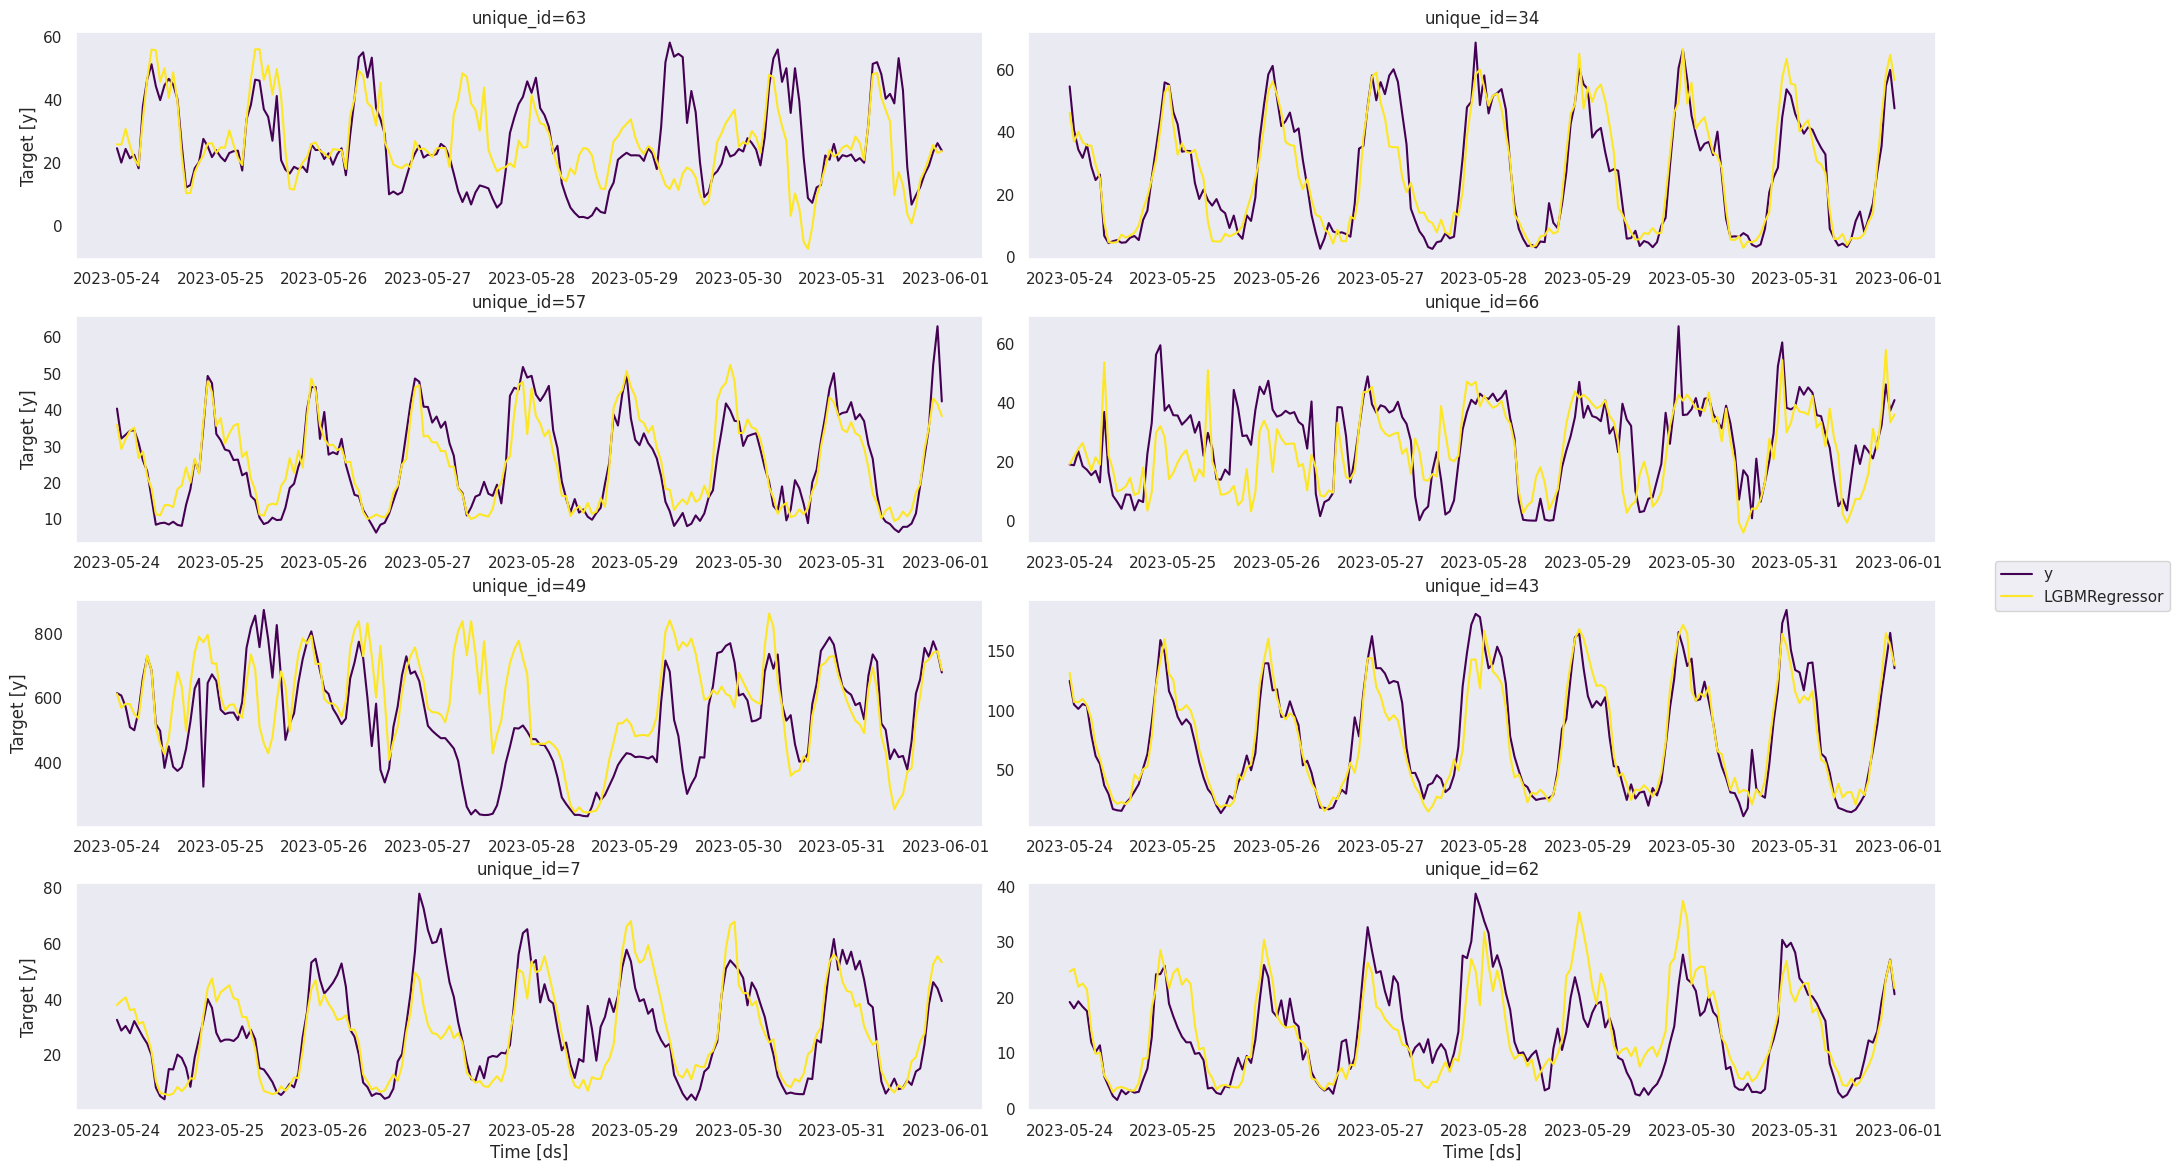

In [39]:
plot_series(cv_result, cv_result.drop(columns='cutoff'), max_insample_length=0)

## Error computation

In [40]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae

def evaluate_cv(df):
    for id_col in cv_result["unique_id"].unique():
        if id_col == cv_result["unique_id"].unique()[0]:
            split_mae = mae(cv_result[cv_result["unique_id"]==id_col], models=['LGBMRegressor'], id_col='cutoff').set_index(np.ones(4, dtype=int)*id_col)
            continue
        split_mae = pd.concat(
            [split_mae, mae(cv_result[cv_result["unique_id"]==id_col], models=['LGBMRegressor'], id_col='cutoff').set_index(np.ones(4, dtype=int)*id_col)]
        )
    split_mae.index = split_mae.index.set_names("unique_id")
    return split_mae

split_mae = evaluate_cv(cv_result)
split_mae

,cutoff,LGBMRegressor
unique_id,,
0,2023-05-23 23:00:00,34.072734
0,2023-05-25 23:00:00,59.636047
0,2023-05-27 23:00:00,43.921305
0,2023-05-29 23:00:00,28.997839
1,2023-05-23 23:00:00,1.771286
...,...,...
67,2023-05-29 23:00:00,53.657846
68,2023-05-23 23:00:00,2.803081
68,2023-05-25 23:00:00,2.453593


## LightGBMCV